### IMPORTS AND LIBRARIES

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

import nltk
import re
import string
import contractions
import inflect
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


### NLTK RESOURCES

In [65]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Asuar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asuar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Asuar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Cargar noticias y datos etiquetados a DF

In [66]:
# --------------------------------------------------------
# Noticias a evaluar
# --------------------------------------------------------

# Estructura del CSV esperada:
# ┌──────────────┬─────────────────┬─────────────────────┬────────────┐
# │   url        │     fecha       |       titulo        │  texto     │
# └──────────────┴─────────────────┴─────────────────────┴────────────┘
# label: (opcional para evaluación) - valores posibles: "izquierda", "centro", "derecha"

df = pd.read_csv(r"../noticias_completas_final.csv", sep="~") 
df = df.dropna(subset=['texto']) 

print(df.head())
print(df.columns)

# --------------------------------------------------------
# Noticias etiquetadas
# --------------------------------------------------------

# Estructura del CSV esperada:
# ┌──────────────┬─────────────────┬─────────────────────┬────────────┬────────────┐
# │   url        │     fecha       |       titulo        │  texto     │   etiqueta │
# └──────────────┴─────────────────┴─────────────────────┴────────────┴────────────┘
# label: (opcional para evaluación) - valores posibles: "izquierda", "centro", "derecha"

#df_et = pd.read_csv(r"../etiquetados2.csv", sep="~") 
df_et = pd.read_csv(r"../etiquetados2.csv", sep="~")
df_et = df_et.dropna(subset=['texto']) 

print("df etiquetado")
print(df_et.head())
df_et.rename(columns={"etiqueta;;;;;": "etiqueta"}, inplace=True)
print(df_et.columns)

print("\n")
# Asegúrate de que todo esté en minúsculas y sin espacios extras
df_et['etiqueta'] = df_et['etiqueta'].str.strip().str.lower()

# Reemplazar variantes por valores correctos
df_et['etiqueta'] = df_et['etiqueta'].replace({
    ' derecha': 'derecha',
    'derecha ': 'derecha',
    'izquierda,': 'izquierda',
    'izquierda,,,,,,,,,,,,,,,,,,,,,,,,,': 'izquierda'
})

# Corregir posibles otros errores con strip() y eliminar nulos
df_et['etiqueta'] = df_et['etiqueta'].str.strip()
df_et = df_et[df_et['etiqueta'].isin(['centro', 'izquierda', 'derecha'])]

# Verificar resultado
print(df_et['etiqueta'].unique())

# imprimir conteo de etiquetas
print(df_et['etiqueta'].value_counts())

print("Cantidad de noticias: " + str(len(df)))

                                                 url                fecha  \
0  https://www.eltiempo.com/economia/sectores/col...  2024-01-02 04:45:00   
1  https://www.eltiempo.com/economia/sectores/pea...  2024-01-02 04:45:00   
2  https://www.eltiempo.com/opinion/editorial/edi...  2024-01-02 02:45:00   
3  https://www.eltiempo.com/economia/sectores/fen...  2024-01-02 12:15:00   
4  https://www.eltiempo.com/vida/educacion/noveda...  2024-01-02 04:45:00   

                                              titulo  \
0  Colombianos tendrán un alivio en alzas que lle...   
1  Peajes y arriendos subirán en el 2024 con el d...   
2  Editorial de EL TIEMPO del 2 de enero de 2024 ...   
3  Fenalco sobre salario mínimo :  Es un alza par...   
4  Novedades del decreto sobre la gratuidad en la...   

                                               texto  
0   El arranque de un nuevo año suele verse empañ...  
1   Uno de los cobros que siguen atados a la infl...  
2  A dos días de terminar el año pa

### Crear DF de noticias por medio de comunicación

In [67]:
# NOTICIAS RCN
df_rcn = pd.DataFrame(columns=["url", "fecha", "titulo", "texto"])

rows_to_append = []  # Temporary list to store rows to append
for _, linea in df.iterrows():
    if "noticiasrcn.com" in linea['url']:
        rows_to_append.append(linea)

# Use pd.concat to append rows
df_rcn = pd.concat([df_rcn, pd.DataFrame(rows_to_append)], ignore_index=True)

# Drop rows with missing 'texto'
df_rcn = df_rcn.dropna(subset=['texto'])

# imprimir cantidad de noticias de rcn
print("Noticias de rcn: ", len(df_rcn))
# ----------------------------------------------------------------------------------

# NOTICIAS EL TIEMPO
df_tiempo = pd.DataFrame(columns=["url", "fecha", "titulo", "texto"])

rows_to_append = []  # Temporary list to store rows to append
for _, linea in df.iterrows():
    if "eltiempo.com" in linea['url']:
        rows_to_append.append(linea)

# Use pd.concat to append rows
df_tiempo = pd.concat([df_tiempo, pd.DataFrame(rows_to_append)], ignore_index=True)

# Drop rows with missing 'texto'
df_tiempo = df_tiempo.dropna(subset=['texto'])

# imprimir cantidad de noticias
print("Noticias de El Tiempo: ", len(df_tiempo))
# ----------------------------------------------------------------------------------

# NOTICIAS EL ESPECTADOR
df_espectador = pd.DataFrame(columns=["url", "fecha", "titulo", "texto"])

rows_to_append = []  # Temporary list to store rows to append
for _, linea in df.iterrows():
    if "elespectador.com" in linea['url']:
        rows_to_append.append(linea)

# Use pd.concat to append rows
df_espectador = pd.concat([df_espectador, pd.DataFrame(rows_to_append)], ignore_index=True)

# Drop rows with missing 'texto'
df_espectador = df_espectador.dropna(subset=['texto'])

# imprimir cantidad de noticias
print("Noticias de El Espectador: ", len(df_espectador))
# ----------------------------------------------------------------------------------  

# NOTICIAS SEMANA
df_semana = pd.DataFrame(columns=["url", "fecha", "titulo", "texto"])

rows_to_append = []  # Temporary list to store rows to append
for _, linea in df.iterrows():
    if "semana.com" in linea['url']:
        rows_to_append.append(linea)

# Use pd.concat to append rows
df_semana = pd.concat([df_semana, pd.DataFrame(rows_to_append)], ignore_index=True)

# Drop rows with missing 'texto'
df_semana = df_semana.dropna(subset=['texto'])

# imprimir cantidad de noticias
print("Noticias de Semana: ", len(df_semana))
# ---------------------------------------------------------------------------------- 

# NOTICIAS PULZO
df_pulzo = pd.DataFrame(columns=["url", "fecha", "titulo", "texto"])

rows_to_append = []  # Temporary list to store rows to append
for _, linea in df.iterrows():
    if "pulzo.com" in linea['url']:
        rows_to_append.append(linea)

# Use pd.concat to append rows
df_pulzo = pd.concat([df_pulzo, pd.DataFrame(rows_to_append)], ignore_index=True)

# Drop rows with missing 'texto'
df_pulzo = df_pulzo.dropna(subset=['texto'])

# imprimir cantidad de noticias
print("Noticias de Pulzo: ", len(df_pulzo))
# ----------------------------------------------------------------------------------

# NOTICIAS LA REPUBLICA
df_republica = pd.DataFrame(columns=["url", "fecha", "titulo", "texto"])

rows_to_append = []  # Temporary list to store rows to append
for _, linea in df.iterrows():
    if "larepublica.co" in linea['url']:
        rows_to_append.append(linea)

# Use pd.concat to append rows
df_republica = pd.concat([df_republica, pd.DataFrame(rows_to_append)], ignore_index=True)

# Drop rows with missing 'texto'
df_republica = df_republica.dropna(subset=['texto'])

# imprimir cantidad de noticias
print("Noticias de La Republica: ", len(df_republica))
# ----------------------------------------------------------------------------------

# NOTICIAS LA REPUBLICA
df_silla = pd.DataFrame(columns=["url", "fecha", "titulo", "texto"])

rows_to_append = []  # Temporary list to store rows to append
for _, linea in df.iterrows():
    if "lasillavacia.com" in linea['url']:
        rows_to_append.append(linea)

# Use pd.concat to append rows
df_silla = pd.concat([df_silla, pd.DataFrame(rows_to_append)], ignore_index=True)

# Drop rows with missing 'texto'
df_silla = df_silla.dropna(subset=['texto'])

# imprimir cantidad de noticias
print("Noticias de La Silla Vacia: ", len(df_silla))


Noticias de rcn:  941
Noticias de El Tiempo:  2274
Noticias de El Espectador:  688
Noticias de Semana:  3151
Noticias de Pulzo:  3521
Noticias de La Republica:  1645
Noticias de La Silla Vacia:  1088


### PREPROCESAMIENTO DE TEXTO

In [68]:
stop_words = set(stopwords.words('spanish'))
lemmatizer = WordNetLemmatizer()
inflect_engine = inflect.engine()

# --------------------------------------------------------
# Noticias a evaluar
# --------------------------------------------------------
def preprocess_text(text):
    # Expandir contracciones
    text = contractions.fix(text)
    
    # Lowercase y eliminar puntuación
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)

    # Tokenizar
    tokens = nltk.word_tokenize(text)

    # Eliminar stopwords y lematizar
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and word.isalpha()]
    
    return " ".join(tokens)

# El completo
df['texto_limpio'] = df['texto'].apply(preprocess_text)

# --------------------------------------------------------
# Para cada medio de comunicación
# --------------------------------------------------------
df_rcn['texto_limpio'] = df_rcn['texto'].apply(preprocess_text)
df_tiempo['texto_limpio'] = df_tiempo['texto'].apply(preprocess_text)
df_espectador['texto_limpio'] = df_espectador['texto'].apply(preprocess_text)
df_semana['texto_limpio'] = df_semana['texto'].apply(preprocess_text)
df_pulzo['texto_limpio'] = df_pulzo['texto'].apply(preprocess_text)
df_republica['texto_limpio'] = df_republica['texto'].apply(preprocess_text)
df_silla['texto_limpio'] = df_silla['texto'].apply(preprocess_text)

# --------------------------------------------------------
# Etiquetadas
# --------------------------------------------------------
def preprocess_text(text):
    # Expandir contracciones
    text = contractions.fix(text)
    
    # Lowercase y eliminar puntuación
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)

    # Tokenizar
    tokens = nltk.word_tokenize(text)

    # Eliminar stopwords y lematizar
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and word.isalpha()]
    
    return " ".join(tokens)

df_et['texto_limpio'] = df_et['texto'].apply(preprocess_text)

### VECTORIZACION

In [69]:
# Entrenamos el vectorizador SOLO con los datos etiquetados
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_etiquetados = vectorizer.fit_transform(df_et['texto_limpio'])  # OK

# Las etiquetas (por ejemplo: 0=izquierda, 1=centro, 2=derecha)
y_etiquetas = df_et['etiqueta']  

### Entrenar el modelo supervisado

In [70]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_etiquetados, y_etiquetas, test_size=0.2, random_state=42, stratify=y_etiquetas)

# Entrenar modelo
modelo = RandomForestClassifier(random_state=42)
modelo.fit(X_train, y_train)

# Evaluar
y_pred = modelo.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

      centro       1.00      0.60      0.75        25
     derecha       0.78      0.90      0.83        50
   izquierda       0.83      0.87      0.85        45

    accuracy                           0.82       120
   macro avg       0.87      0.79      0.81       120
weighted avg       0.84      0.82      0.82       120



### Guardar modelo entrenado

In [71]:
import joblib
joblib.dump(modelo, "modelo_ideologia.pkl")
joblib.dump(vectorizer, "vectorizer_tfidf.pkl")


['vectorizer_tfidf.pkl']

### Usar modelo en las noticias y visualizar resultado

                                               titulo prediccion_ideologia
0   Colombianos tendrán un alivio en alzas que lle...              derecha
1   Peajes y arriendos subirán en el 2024 con el d...               centro
2   Editorial de EL TIEMPO del 2 de enero de 2024 ...            izquierda
3   Fenalco sobre salario mínimo :  Es un alza par...            izquierda
4   Novedades del decreto sobre la gratuidad en la...               centro
5   Editorial de EL TIEMPO del 2 de enero de 2024 ...            izquierda
6   Carlos Fernando Galán : Minuto a minuto de la ...            izquierda
7   Este es el incremento que tendrán las cuotas m...               centro
9   Brasil : Lula da Silva cumple un año de gobier...               centro
10  Antioquia : este es el gabinete de Andrés Juli...            izquierda


C:\Users\Asuar\AppData\Local\Temp\ipykernel_81872\2593291636.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=conteo_etiquetas.index, y=conteo_etiquetas.values, palette='viridis')


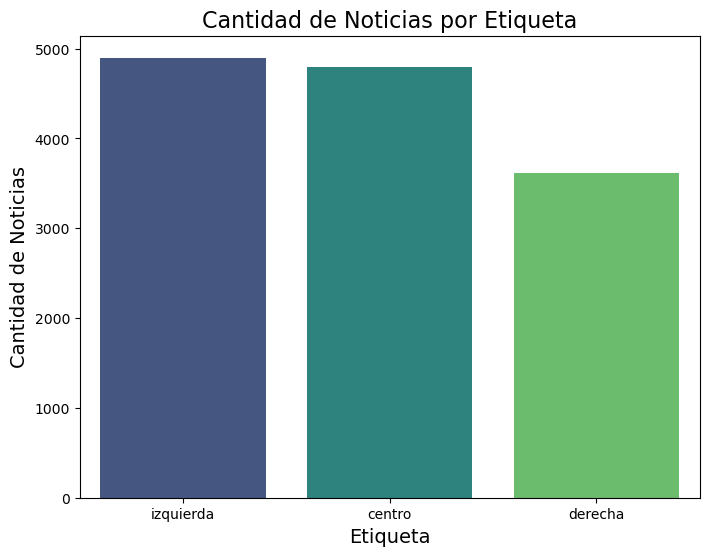

In [72]:
X_nuevas = vectorizer.transform(df['texto_limpio']).toarray()
df['prediccion_ideologia'] = modelo.predict(X_nuevas)

print(df[['titulo', 'prediccion_ideologia']].head(10))


#-----------------------------------------------------------------

# Contar las ocurrencias de cada etiqueta
conteo_etiquetas = df['prediccion_ideologia'].value_counts()

# Crear un gráfico de barras
plt.figure(figsize=(8,6))
sns.barplot(x=conteo_etiquetas.index, y=conteo_etiquetas.values, palette='viridis')

# Títulos y etiquetas
plt.title('Cantidad de Noticias por Etiqueta', fontsize=16)
plt.xlabel('Etiqueta', fontsize=14)
plt.ylabel('Cantidad de Noticias', fontsize=14)

# Mostrar el gráfico
plt.show()


### Clasificación con etiquetas para cada medio poltítico

RCN

                                                titulo  \
0    Reacciones negativas por crecimiento del PIB c...   
1    Precio del dólar en Colombia 7 de febrero del ...   
2    Los cinco vehículos eléctricos más economicos ...   
3    Ganado en pie : camino para la internacionaliz...   
4    Países más baratos de Europa para viajar desde...   
..                                                 ...   
936                                Ella me dijo : papi   
937  Biodiversidad en riesgo en Colombia : grupos a...   
938                  Por una mujer cayó  Jeison Comino   
939  Ojo : clientes de bancos en Colombia deben hac...   
940  Plan Navidad 2024 : 18 mil uniformados vigilar...   

                                                 texto  
0    Es preocupante el ritmo que tiene la economía ...  
1    Este miércoles el dólar registró un leve incre...  
2    ¿Buscando un carro con gran autonomía, económi...  
3    El reciente informe del DANE sobre las exporta...  
4    Sin duda algu

C:\Users\Asuar\AppData\Local\Temp\ipykernel_81872\1149606198.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=conteo_etiquetas.index, y=conteo_etiquetas.values, palette='viridis')


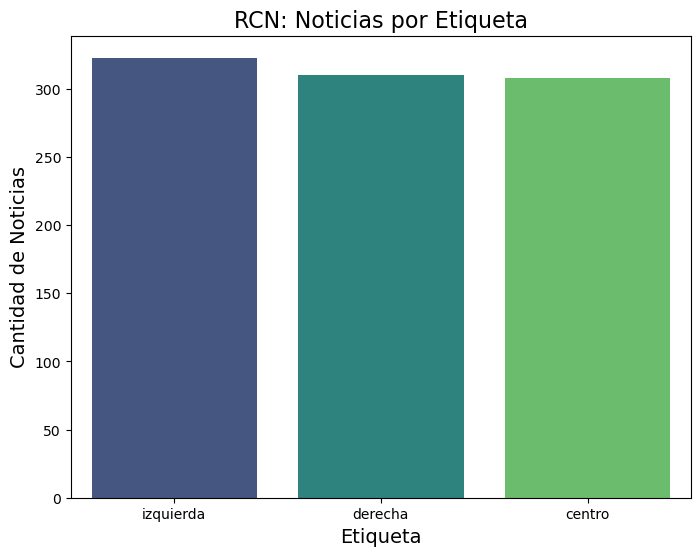

In [73]:
print(df_rcn[['titulo', 'texto']])

X_rcn = vectorizer.transform(df_rcn['texto_limpio']).toarray()
df_rcn['prediccion_ideologia'] = modelo.predict(X_rcn)

print(df_rcn[['titulo', 'prediccion_ideologia']].head(10))


#-----------------------------------------------------------------
# Contar las ocurrencias de cada etiqueta
conteo_etiquetas = df_rcn['prediccion_ideologia'].value_counts()

# Crear un gráfico de barras
plt.figure(figsize=(8,6))
sns.barplot(x=conteo_etiquetas.index, y=conteo_etiquetas.values, palette='viridis')

# Títulos y etiquetas
plt.title('RCN: Noticias por Etiqueta', fontsize=16)
plt.xlabel('Etiqueta', fontsize=14)
plt.ylabel('Cantidad de Noticias', fontsize=14)

# Mostrar el gráfico
plt.show()

# Exportar CSV
df_rcn.to_csv("../ResultadosMedios/rcn_etiquetadas.csv", sep="~", index=False)

El Tiempo

                                                 titulo  \
0     Colombianos tendrán un alivio en alzas que lle...   
1     Peajes y arriendos subirán en el 2024 con el d...   
2     Editorial de EL TIEMPO del 2 de enero de 2024 ...   
3     Fenalco sobre salario mínimo :  Es un alza par...   
4     Novedades del decreto sobre la gratuidad en la...   
...                                                 ...   
2269  Así fue la migración en el mundo este 2024 : d...   
2270                              Educación para la paz   
2271  La demolición en marcha / Análisis de Ricardo ...   
2272  Fiscalía sacó nueva resolución para negociar p...   
2273                          El largo dosier de  Barba   

                                                  texto  
0      El arranque de un nuevo año suele verse empañ...  
1      Uno de los cobros que siguen atados a la infl...  
2     A dos días de terminar el año pasado, el Gobie...  
3      Mientras el Gobierno Nacional señala que el a...  
4

C:\Users\Asuar\AppData\Local\Temp\ipykernel_81872\2335138360.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=conteo_etiquetas.index, y=conteo_etiquetas.values, palette='viridis')


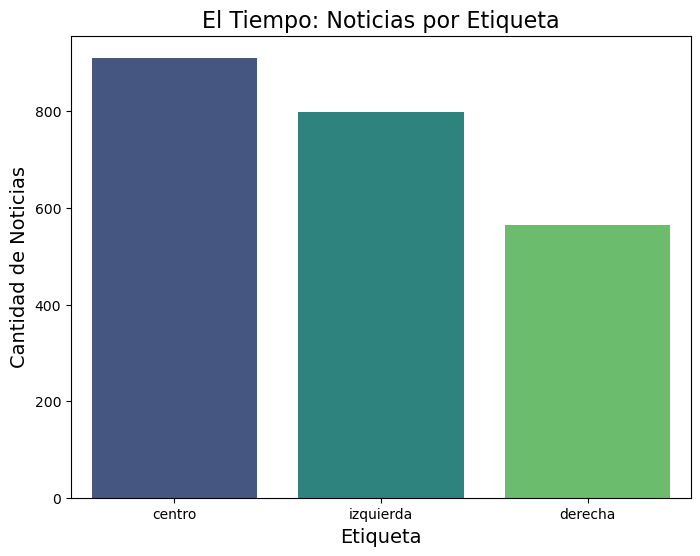

In [ ]:
print(df_tiempo[['titulo', 'texto']])

X_tiempo = vectorizer.transform(df_tiempo['texto_limpio']).toarray()
df_tiempo['prediccion_ideologia'] = modelo.predict(X_tiempo)

print(df_tiempo[['titulo', 'prediccion_ideologia']].head(10))


#-----------------------------------------------------------------
# Contar las ocurrencias de cada etiqueta
conteo_etiquetas = df_tiempo['prediccion_ideologia'].value_counts()

# Crear un gráfico de barras
plt.figure(figsize=(8,6))
sns.barplot(x=conteo_etiquetas.index, y=conteo_etiquetas.values, palette='viridis')

# Títulos y etiquetas
plt.title('El Tiempo: Noticias por Etiqueta', fontsize=16)
plt.xlabel('Etiqueta', fontsize=14)
plt.ylabel('Cantidad de Noticias', fontsize=14)

# Mostrar el gráfico
plt.show()

# Exportar CSV
df_tiempo.to_csv("../ResultadosMedios/eltiempo_etiquetadas.csv", sep="~", index=False)

El Espectador

                                                titulo  \
0    Este fue el PIB de Colombia PIB de 2023 : la e...   
1    El rumbo del dólar : ¿ qué podría afectar la t...   
2    Colombia tuvo récord en turistas en 2023 : ¿ q...   
3    Autorizada aerolínea Emirates para cubrir la r...   
4                                        Tour Colombia   
..                                                 ...   
683  Conozca algunas de las obras que se presentará...   
684  Comuna 13 de Medellín : El testimonio de un ni...   
685  Reclutamiento de menores de edad en Colombia p...   
686  20 - 21 ODISEA en el ESPACIO … by N . Q . G | ...   
687    Sin predicciones : la guerra en Ucrania en 2025   

                                                 texto  
0    Imagen de referencia. Foto: Getty Images/iStoc...  
1    Foto: Agencia Bloomberg Resume e infórmame ráp...  
2    Hotel Zuana, playa bandera azul. Foto: Cortesí...  
3    La aerolínea prevé cubrir la ruta Bogotá-Dubái...  
4     caso Odebrec

C:\Users\Asuar\AppData\Local\Temp\ipykernel_81872\2600660084.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=conteo_etiquetas.index, y=conteo_etiquetas.values, palette='viridis')


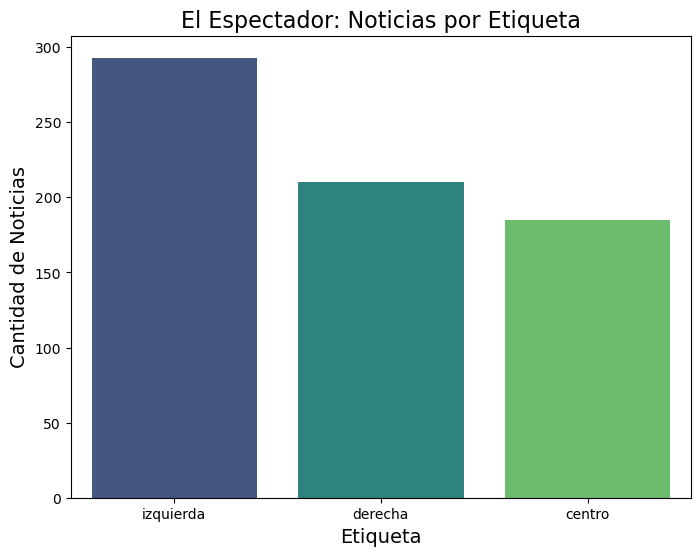

In [ ]:
print(df_espectador[['titulo', 'texto']])
X_espectador = vectorizer.transform(df_espectador['texto_limpio']).toarray()
df_espectador['prediccion_ideologia'] = modelo.predict(X_espectador)
print(df_espectador[['titulo', 'prediccion_ideologia']].head(10))

#-----------------------------------------------------------------
# Contar las ocurrencias de cada etiqueta
conteo_etiquetas = df_espectador['prediccion_ideologia'].value_counts()

# Crear un gráfico de barras
plt.figure(figsize=(8,6))
sns.barplot(x=conteo_etiquetas.index, y=conteo_etiquetas.values, palette='viridis')

# Títulos y etiquetas
plt.title('El Espectador: Noticias por Etiqueta', fontsize=16)
plt.xlabel('Etiqueta', fontsize=14)
plt.ylabel('Cantidad de Noticias', fontsize=14)

# Mostrar el gráfico
plt.show()

# Exportar CSV
df_espectador.to_csv("../ResultadosMedios/elespectador_etiquetadas.csv", sep="~", index=False)


Semana

                                                 titulo  \
0     Mercado de trabajo : El 2024 será un año de in...   
1     Exclusivo | Contralor en funciones anuncia que...   
2     Nuevo encontrón entre Petro y el exministro Jo...   
3     Daniel Briceño le canta la tabla a Petro por b...   
4     DANE y FMI alertan sobre la economía colombian...   
...                                                 ...   
3146  Narcotraficante colombiano tenía millonario fi...   
3147  Bloque Resistencia Caribe : ¿ La estrategia de...   
3148  Narcos están usando al río Cauca para sacar co...   
3149  Cómo Alquería está convirtiendo a Cundinamarca...   
3150                                         Smartfilms   

                                                  texto  
0     La semana antepasada, la Fundación del Español...  
1     En entrevista con SEMANA, el vicecontralor en ...  
2     Una discusión respetuosa se observó este domin...  
3     El Departamento Administrativo Nacional de Est...  
4

C:\Users\Asuar\AppData\Local\Temp\ipykernel_81872\3886441194.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=conteo_etiquetas.index, y=conteo_etiquetas.values, palette='viridis')


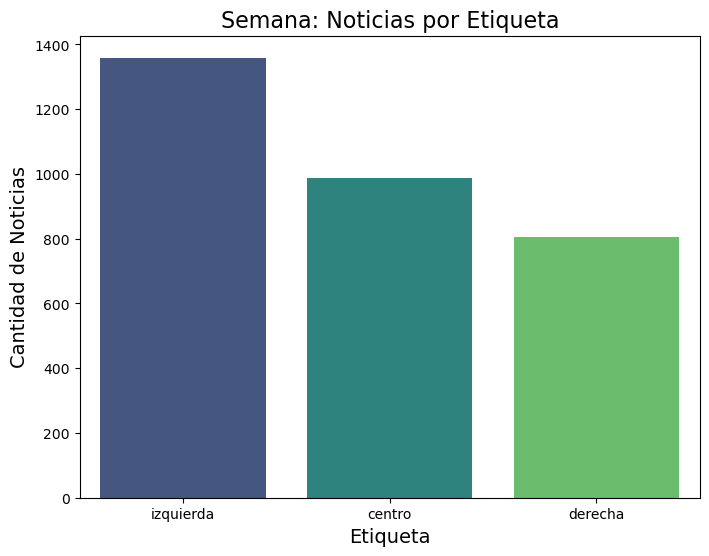

In [ ]:
print(df_semana[['titulo', 'texto']])
X_semana = vectorizer.transform(df_semana['texto_limpio']).toarray()
df_semana['prediccion_ideologia'] = modelo.predict(X_semana)
print(df_semana[['titulo', 'prediccion_ideologia']].head(10))

#-----------------------------------------------------------------
# Contar las ocurrencias de cada etiqueta
conteo_etiquetas = df_semana['prediccion_ideologia'].value_counts()
# Crear un gráfico de barras
plt.figure(figsize=(8,6))
sns.barplot(x=conteo_etiquetas.index, y=conteo_etiquetas.values, palette='viridis')
# Títulos y etiquetas
plt.title('Semana: Noticias por Etiqueta', fontsize=16)
plt.xlabel('Etiqueta', fontsize=14)
plt.ylabel('Cantidad de Noticias', fontsize=14)
# Mostrar el gráfico
plt.show()

# Exportar CSV
df_semana.to_csv("../ResultadosMedios/semana_etiquetadas.csv", sep="~", index=False)

Pulzo

                                                 titulo  \
0                                                Yamaha   
1                                            Volkswagen   
2     Cuáles serán las vías 4G que se entregarán en ...   
3     Dólar hoy en Colombia arrancó 2024 con fuerte ...   
4     Explican cómo será la nueva reforma tributaria...   
...                                                 ...   
3516                                     Tren de Aragua   
3517  Asesinato empleada de SuperGiros : incendian t...   
3518  Fedemunicipios hace llamado a Gobierno Naciona...   
3519                                     Luigi Mangione   
3520  Identificaron a gerente de joyería que fue ase...   

                                                  texto  
0      Bajaj , AKT y otras marcas de motos tuvieron ...  
1      Suzuki y otras marcas a las que nos les fue b...  
2     Por: VALORA ANALITIK Suministro de información...  
3     Por: VALORA ANALITIK Suministro de información...  
4

C:\Users\Asuar\AppData\Local\Temp\ipykernel_81872\3422143194.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=conteo_etiquetas.index, y=conteo_etiquetas.values, palette='viridis')


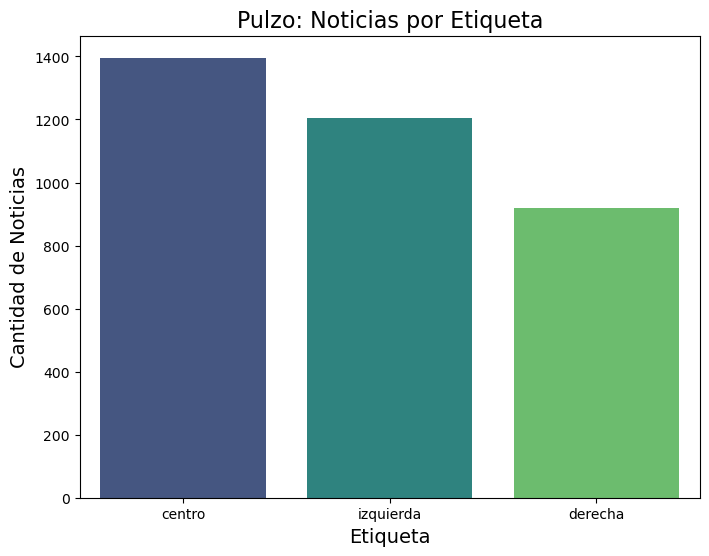

In [ ]:
print(df_pulzo[['titulo', 'texto']])
X_pulzo = vectorizer.transform(df_pulzo['texto_limpio']).toarray()
df_pulzo['prediccion_ideologia'] = modelo.predict(X_pulzo)
print(df_pulzo[['titulo', 'prediccion_ideologia']].head(10))

#-----------------------------------------------------------------
# Contar las ocurrencias de cada etiqueta
conteo_etiquetas = df_pulzo['prediccion_ideologia'].value_counts()
# Crear un gráfico de barras
plt.figure(figsize=(8,6))
sns.barplot(x=conteo_etiquetas.index, y=conteo_etiquetas.values, palette='viridis')
# Títulos y etiquetas
plt.title('Pulzo: Noticias por Etiqueta', fontsize=16)
plt.xlabel('Etiqueta', fontsize=14)
plt.ylabel('Cantidad de Noticias', fontsize=14)
# Mostrar el gráfico
plt.show()

# Exportar CSV
df_pulzo.to_csv("../ResultadosMedios/pulzo_etiquetadas.csv", sep="~", index=False)

La República

                                                 titulo  \
0                                     Según MinHacienda   
1     ¿ Qué gobierno hizo el mayor aumento real del ...   
2     Así le fue al PIB de Colombia el cuarto trimes...   
3     Colombia retrocedió del puesto 62 al 84 en el ...   
4     Mucha gente todavía ve el lucro como algo inmoral   
...                                                 ...   
1640  Colombia se ubicó en el puesto 16 entre los 20...   
1641                            Creatividad gota a gota   
1642  Estas son las coberturas de las aseguradoras p...   
1643  En Colombia nos hemos propuesto reducir 60 % d...   
1644  La integración completa de operación de nuam e...   

                                                  texto  
0      trabajadores ganarían 13 puntos de poder adqu...  
1     Economistas analizan las cifras ofrecidas por ...  
2     El cuarto trimestre de 2023, el PIB creció sol...  
3     El país obtuvo una calificación de 59,2 sobre ...  
4

C:\Users\Asuar\AppData\Local\Temp\ipykernel_81872\2932115548.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=conteo_etiquetas.index, y=conteo_etiquetas.values, palette='viridis')


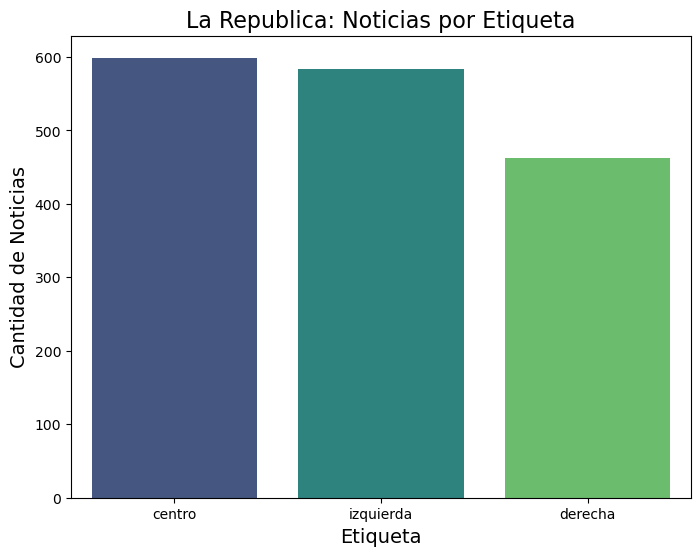

In [ ]:
print(df_republica[['titulo', 'texto']])
X_republica = vectorizer.transform(df_republica['texto_limpio']).toarray()
df_republica['prediccion_ideologia'] = modelo.predict(X_republica)
print(df_republica[['titulo', 'prediccion_ideologia']].head(10))

#-----------------------------------------------------------------
# Contar las ocurrencias de cada etiqueta
conteo_etiquetas = df_republica['prediccion_ideologia'].value_counts()
# Crear un gráfico de barras
plt.figure(figsize=(8,6))
sns.barplot(x=conteo_etiquetas.index, y=conteo_etiquetas.values, palette='viridis')
# Títulos y etiquetas
plt.title('La Republica: Noticias por Etiqueta', fontsize=16)
plt.xlabel('Etiqueta', fontsize=14)
plt.ylabel('Cantidad de Noticias', fontsize=14)
# Mostrar el gráfico
plt.show()

# Exportar CSV
df_republica.to_csv("../ResultadosMedios/larepublica_etiquetadas.csv", sep="~", index=False)

La Silla Vacía

                                                 titulo  \
0     El MinDefensa debe ayudarnos : Dilian Toro en ...   
1     Detector : en marzo de 2023 el FMI destacó med...   
2                    El fin de los estratos explicado .   
3             Petro pide levantar el bloqueo venezolano   
4                                El crecimiento del PIB   
...                                                 ...   
1083  JEP solicita audiencia presencial con el exFar...   
1084  El lenguaje como herramienta de opresión y res...   
1085  Disidencias y ELN : la mayor amenaza terrorist...   
1086  Bandas criminales de Quibdó pactan tregua de d...   
1087  La niñez arrasada por el reclutamiento de las ...   

                                                  texto  
0     Después de una misa, se llevó a cabo la posesi...  
1     Al chat de WhatsApp de La Silla Vacía (+57 310...  
2     El gobierno de Petro ya arrancó el revolcón pa...  
3      y elecciones libres,En su cuenta de Twitter (...  
4

C:\Users\Asuar\AppData\Local\Temp\ipykernel_81872\4265739344.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=conteo_etiquetas.index, y=conteo_etiquetas.values, palette='viridis')


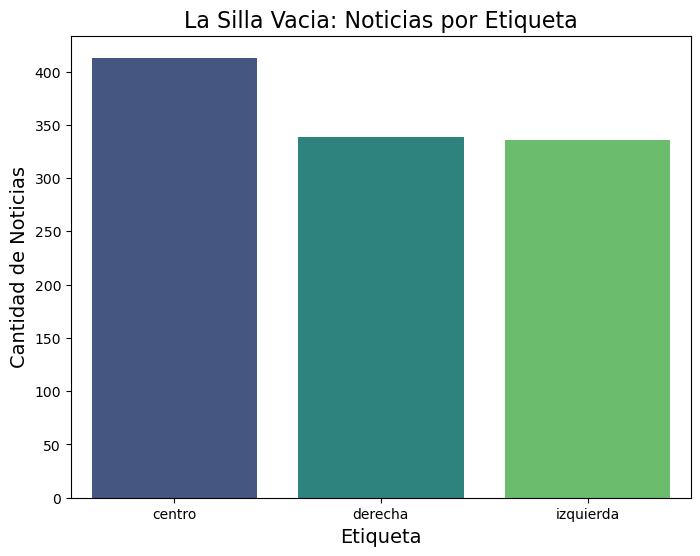

In [ ]:
print(df_silla[['titulo', 'texto']])
X_silla = vectorizer.transform(df_silla['texto_limpio']).toarray()
df_silla['prediccion_ideologia'] = modelo.predict(X_silla)
print(df_silla[['titulo', 'prediccion_ideologia']].head(10))

#-----------------------------------------------------------------
# Contar las ocurrencias de cada etiqueta
conteo_etiquetas = df_silla['prediccion_ideologia'].value_counts()
# Crear un gráfico de barras
plt.figure(figsize=(8,6))
sns.barplot(x=conteo_etiquetas.index, y=conteo_etiquetas.values, palette='viridis')
# Títulos y etiquetas
plt.title('La Silla Vacia: Noticias por Etiqueta', fontsize=16)
plt.xlabel('Etiqueta', fontsize=14)
plt.ylabel('Cantidad de Noticias', fontsize=14)
# Mostrar el gráfico
plt.show()

# Exportar CSV
df_silla.to_csv("../ResultadosMedios/lasillavacia_etiquetadas.csv", sep="~", index=False)

### K - MEANS

In [80]:
# vectorizamos ahora para k-means
# Entrenamos el vectorizador SOLO con los datos etiquetados
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X = vectorizer.fit_transform(df['texto_limpio'])  # OK

k = 2  # para izquierda, centro, derecha
model = KMeans(n_clusters=k, random_state=42)
df['cluster'] = model.fit_predict(X)

print(df[['texto', 'cluster']].head())



                                               texto  cluster
0   El arranque de un nuevo año suele verse empañ...        1
1   Uno de los cobros que siguen atados a la infl...        1
2  A dos días de terminar el año pasado, el Gobie...        1
3   Mientras el Gobierno Nacional señala que el a...        1
4   Con la expedición del Decreto 2271 de 2023, e...        1


#### EVALUACION

In [81]:
score = silhouette_score(X, df['cluster'])
print(f"Silhouette Score: {score:.3f}")


Silhouette Score: 0.006


#### VISUALIZACION

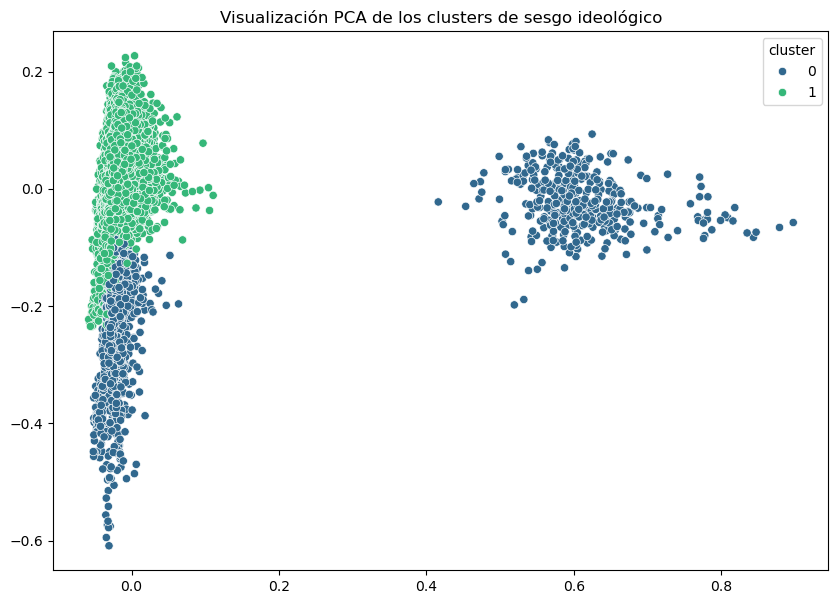

In [82]:
pca = PCA(n_components=2, random_state=42)
components = pca.fit_transform(X)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=components[:, 0], y=components[:, 1], hue=df['cluster'], palette="viridis")
plt.title("Visualización PCA de los clusters de sesgo ideológico")
plt.show()


#### KEY - WORDS

In [83]:
def top_terms_per_cluster(tfidf, labels, vectorizer, n=10):
    order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names_out()
    
    for i in range(k):
        print(f"Cluster {i}:")
        print(", ".join([terms[ind] for ind in order_centroids[i, :n]]))
        print()

top_terms_per_cluster(X, df['cluster'], vectorizer)


Cluster 0:
visitar sitio, visitar, sitio, analitik, valora analitik, valora, información, financiera bursátil, bursátil visitar, suministro información

Cluster 1:
petro, colombia, presidente, gobierno, país, gustavo, nacional, gustavo petro, años, año



In [84]:
# Mapea manualmente los clusters a ideologías
cluster_map = {
    0: "derecha",    # <- ajusta esto según tu análisis
    1: "centro",
    2: "izquierda"
}

df['ideologia'] = df['cluster'].map(cluster_map)


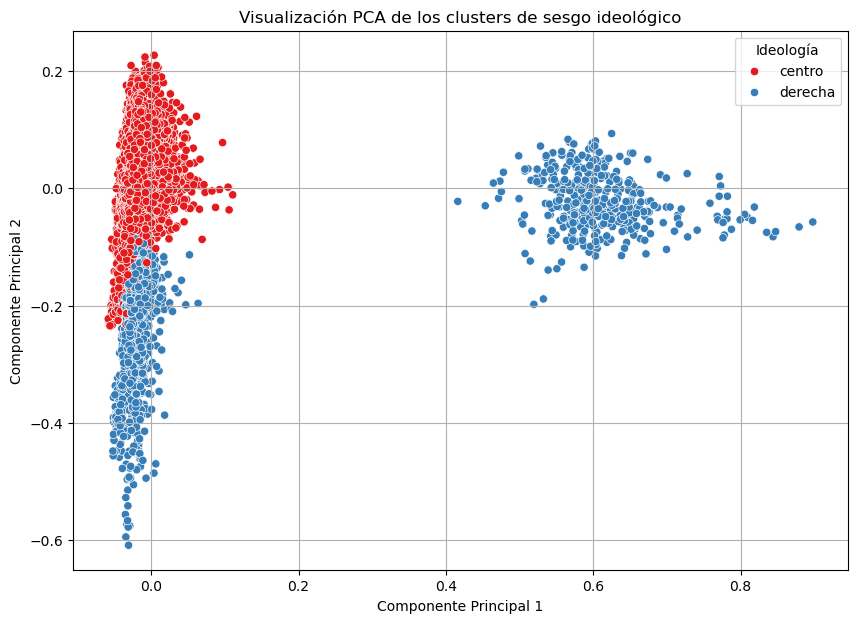

In [85]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=2, random_state=42)
components = pca.fit_transform(X)

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=components[:, 0], 
    y=components[:, 1], 
    hue=df['ideologia'],  # usamos las etiquetas
    palette="Set1"
)
plt.title("Visualización PCA de los clusters de sesgo ideológico")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Ideología")
plt.grid(True)
plt.show()
